## Классификация двух лун при помощи RNN

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle
import mlflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from mlflow.models import infer_signature
from mlflow.tensorflow import save_model, log_model
import tensorflow as tf
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import warnings

warnings.filterwarnings("ignore")

## Создание эксперимента в MLflow где будут храниться запуски

In [7]:
mlflow.tensorflow.autolog()
experiment = mlflow.set_experiment("HalfMoons")

tf.random.set_seed(1)

## Класс описывающий все изменения с данными и обучением модели

In [8]:
class MoonsClassifier:
    def __init__(self, n_input, epochs):
        self.file_path_model = f"models\model_{str(epochs)}_{n_input}.pkl"
        self.n_input = n_input
        self.train_X, self.test_X, self.train_y, self.test_y = self.generate_moons()
        self.train_size = 800
        self.epochs = epochs
        self.n_features = 2
        self.batch_size = 1

    def save_model_rnn(self):
        with open(self.file_path_model, 'wb') as f:
            model = self.fit_model_lstm()
            pickle.dump(model, f)

    def generate_moons(self):
        X, y = make_moons(noise=0.1, random_state=1, n_samples=1000)
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
        return train_X, test_X, train_y, test_y

    def create_model_lstm(self):
        lstm_model = Sequential()
        lstm_model.add(LSTM(100, activation='tanh', input_shape=(self.n_input, self.n_features)))
        lstm_model.add(Dense(1, activation='tanh'))
        lstm_model.compile(optimizer='adam', loss='mae')
        return lstm_model

    def fit_model_lstm(self):
        model = self.create_model_lstm()
        print(np.array(self.train_X.reshape(len(self.train_y), 2, 1)).shape, np.array(self.train_y.shape))
        model.fit(self.train_X.reshape(len(self.train_y), 1, 2), self.train_y.reshape(-1, 1), epochs=self.epochs)
        return model

    def get_predictions(self):
        model = self.load_model()
        predictions = model.predict(self.test_X.reshape(len(self.test_y), 1, 2))
        return predictions

    def load_model(self):
        if not os.path.exists(self.file_path_model):
            self.save_model_rnn()
        elif not os.path.getsize(self.file_path_model) > 0:
            os.remove(self.file_path_model)
            self.save_model_rnn()

        if os.path.getsize(self.file_path_model) > 0:
            with open(self.file_path_model, "rb") as f:
                unpickler = pickle.Unpickler(f)
                model = unpickler.load()
                return model

    def show_result(self):
        model, predictions, train_X, test_X, train_y, test_y = self.get_result()
        plt.scatter(test_X.transpose()[0][predictions.transpose()[0]>0.5], test_X.transpose()[1][predictions.transpose()[0]>0.5], c='g', label=r'class 1')
        plt.scatter(test_X.transpose()[0][predictions.transpose()[0]<0.5], test_X.transpose()[1][predictions.transpose()[0]<0.5], c='y', label=r'class 0')
        plt.legend(loc='best', fontsize=12)
        plt.grid(True)
        plt.xlabel(r'Признак 1', fontsize=9)
        plt.ylabel(r'Признак 2', fontsize=9)
        plt.show()

    def get_result(self):
        predictions = self.get_predictions()
        model = self.load_model()
        return model, predictions, self.train_X, self.test_X, self.train_y, self.test_y


## Функция для отображения разделяющей гиперплоскости

In [9]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    aa, bb = np.meshgrid(hticks, vticks)
    
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab.reshape(len(ab), 1, 2))
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)

    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.show()

## Эксперимент классификации двух полулун с использованием слоя RNN(LSTM)

11/11 [==============================] - 0s 897us/step


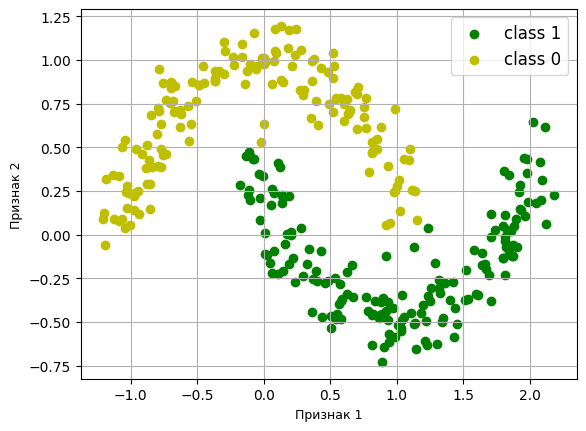

In [10]:
cl = MoonsClassifier(1, 500)
cl.show_result()

In [12]:
model, predictions, train_X, test_X, train_y, test_y = cl.get_result()

11/11 [==============================] - 0s 899us/step


319/319 [==============================] - 1s 1ms/step


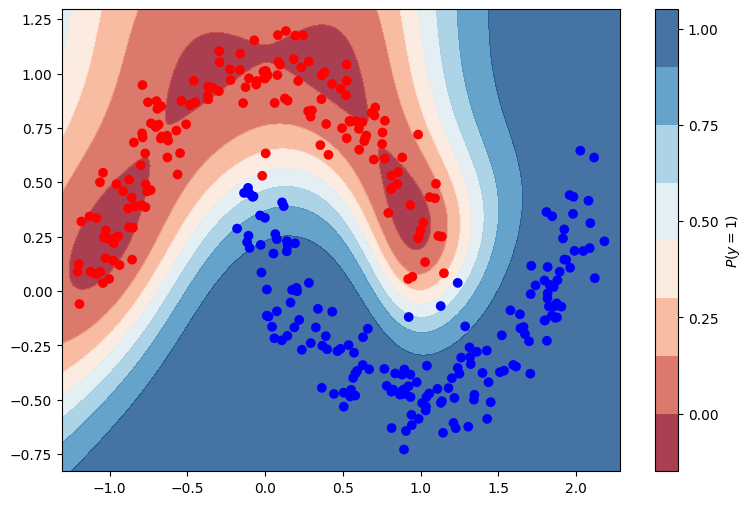

In [13]:
plot_decision_boundary(model.predict, test_X, np.round(predictions.transpose()[0].tolist()))